### LSTM을 통해 셰익스피어 작품을 학습한 후 문장의 다음 단어를 예측 (
machine learning cookbook 
#### import library

In [1]:
import os
import re
import string
import requests
import numpy as np
import collections
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

#### RNN변수 설정

In [2]:
sess = tf.Session()

min_word_freq = 5         #빈도가 낮은 단어 제외
rnn_size = 128            #rnn 모델 크기, 임베딩 크기와 동일
epochs = 10
batch_size = 100
learning_rate = 0.001     #학습률
training_seq_len = 50     # 고려 대상인 단어 묶음 길이 
embedding_size = rnn_size
save_every = 500          #모델 확인 및 저장 주기 
eval_every = 50           # 테스트 문장 평가 주기
prime_texts = ['thou art more' ,'to be or not to', 'wherefore art thou']

#### 데이터 준비

In [3]:
data_dir = 'temp_shakespeare'
data_file = 'shakespeare.txt'
model_path = 'shakespeare_model'
full_model_dir = os.path.join(data_dir, model_path)

punctuation = string.punctuation
punctuation = ''.join([x for x in punctuation if x not in ['-', "'"]])

if not os.path.exists(full_model_dir):
    os.makedirs(full_model_dir)
    
#데이터 디렉토리 생성
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
print ('Loading Shakespeare Data')

#파일 다운로드 여부 확인
if not os.path.isfile(os.path.join(data_dir, data_file)):
    print ('Not found, downloading Shakespeare texts from www..gutenberg.org')
    
    shakespeare_url = "http://www.gutenberg.org/chche/epub/100/pg100.txt"
    
    #셰익스피어 문서 받기
    response = requests.get(shakespeare_url)
    shakespeare_file = response.content
    
    #이진 문자열 변환
    s_text = shakespeare_file.decode('utf-8')
    #초반 설명 단락 제거
    s_text =s_text[7675:]
    #개행 문자 제거 
    s_text = s_text.replace('\r\n',"")
    s_text = s_text.replace('\n',"")

    #파일 저장
    with open(os.path.join(data_dir, data_file), 'w') as out_conn:
        out_conn.write(s_text)
else:
    #저장된 파일이 있으면 해당 파일 로드
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        s_text = file_conn.read().replace('\n','')



Loading Shakespeare Data


#### 기호 및 공백 제거

In [4]:
s_text = re.sub(r'[{}]'.format(punctuation), ' ', s_text)
s_text = re.sub('\s+', ' ', s_text).strip().lower()

#### 어휘사전 생성 

특정 빈도 이상 출현하는 단어들에 대해 두종류의 사전 반환

In [5]:
def build_vocab(text,min_word_freq):
    word_count = collections.Counter(text.split(' '))
    
    #특정 값보다 빈도가 높은 경우 빈도 값의 상한을 설정
    word_count = {key:val for key, val in word_count.items() if val > min_word_freq}
    
    #단어 -> 색인값대응
    words = word_count.keys()
    vocab_to_ix_dict = {key:(ix+1) for ix, key in enumerate(words)} # 1부터 시작
    
    #알 수 없음에 해당하는 색인 값 0 추가
    vocab_to_ix_dict['unknown']=0
    
    #색인 값 -> 단어 대응
    ix_to_vocab_dict = {val:key for key, val in vocab_to_ix_dict.items()}
    
    return (ix_to_vocab_dict, vocab_to_ix_dict)

ix2vocab, vocab2ix = build_vocab(s_text, min_word_freq)
vocab_size = len(ix2vocab) + 1

#### 문서를 색인 값 배열로 변환

In [6]:
s_text_words = s_text.split(' ')
s_text_ix =[]
for ix, x in enumerate(s_text_words):
    try:
        s_text_ix.append(vocab2ix[x])
    except:
        s_text_ix.append(0)
s_text_ix = np.array(s_text_ix)

In [7]:
# Define LSTM RNN Model
class LSTM_Model():
    def __init__(self, embedding_size, rnn_size, batch_size, learning_rate,
                 training_seq_len, vocab_size, infer_sample=False):
        self.embedding_size = embedding_size
        self.rnn_size = rnn_size
        self.vocab_size = vocab_size
        self.infer_sample = infer_sample
        self.learning_rate = learning_rate
        
        if infer_sample:
            self.batch_size = 1
            self.training_seq_len = 1
        else:
            self.batch_size = batch_size
            self.training_seq_len = training_seq_len
        
        self.lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.rnn_size)
        self.initial_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)
        
        self.x_data = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        self.y_output = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        
        with tf.variable_scope('lstm_vars'):
            # Softmax Output Weights
            W = tf.get_variable('W', [self.rnn_size, self.vocab_size], tf.float32, tf.random_normal_initializer())
            b = tf.get_variable('b', [self.vocab_size], tf.float32, tf.constant_initializer(0.0))
        
            # Define Embedding
            embedding_mat = tf.get_variable('embedding_mat', [self.vocab_size, self.embedding_size],
                                            tf.float32, tf.random_normal_initializer())
                                            
            embedding_output = tf.nn.embedding_lookup(embedding_mat, self.x_data)
            rnn_inputs = tf.split(axis=1, num_or_size_splits=self.training_seq_len, value=embedding_output)
            rnn_inputs_trimmed = [tf.squeeze(x, [1]) for x in rnn_inputs]
        
        # If we are inferring (generating text), we add a 'loop' function
        # Define how to get the i+1 th input from the i th output
        def inferred_loop(prev, count):
            # Apply hidden layer
            prev_transformed = tf.matmul(prev, W) + b
            # Get the index of the output (also don't run the gradient)
            prev_symbol = tf.stop_gradient(tf.argmax(prev_transformed, 1))
            # Get embedded vector
            output = tf.nn.embedding_lookup(embedding_mat, prev_symbol)
            return(output)
        
        decoder = tf.contrib.legacy_seq2seq.rnn_decoder
        outputs, last_state = decoder(rnn_inputs_trimmed,
                                      self.initial_state,
                                      self.lstm_cell,
                                      loop_function=inferred_loop if infer_sample else None)
        # Non inferred outputs
        output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, self.rnn_size])
        # Logits and output
        self.logit_output = tf.matmul(output, W) + b
        self.model_output = tf.nn.softmax(self.logit_output)
        
        loss_fun = tf.contrib.legacy_seq2seq.sequence_loss_by_example
        loss = loss_fun([self.logit_output],[tf.reshape(self.y_output, [-1])],
                [tf.ones([self.batch_size * self.training_seq_len])],
                self.vocab_size)
        self.cost = tf.reduce_sum(loss) / (self.batch_size * self.training_seq_len)
        self.final_state = last_state
        gradients, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tf.trainable_variables()), 4.5)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
        
    def sample(self, sess, words=ix2vocab, vocab=vocab2ix, num=10, prime_text='thou art'):
        state = sess.run(self.lstm_cell.zero_state(1, tf.float32))
        word_list = prime_text.split()
        for word in word_list[:-1]:
            x = np.zeros((1, 1))
            x[0,0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [state] = sess.run([self.final_state], feed_dict=feed_dict)

        out_sentence = prime_text
        word = word_list[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [model_output, state] = sess.run([self.model_output, self.final_state], feed_dict=feed_dict)
            sample = np.argmax(model_output[0])
            if sample == 0:
                break
            word = words[sample]
            out_sentence = out_sentence + ' ' + word
        return(out_sentence)

#### 테스트모델, LSTM모델 선언

In [8]:
# Define LSTM Model
lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                        training_seq_len, vocab_size)

# Tell TensorFlow we are reusing the scope for the testing
with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    test_lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                                 training_seq_len, vocab_size, infer_sample=True)

In [12]:
saver = tf.train.Saver(tf.global_variables())

# Create batches for each epoch
num_batches = int(len(s_text_ix)/(batch_size * training_seq_len)) + 1
# Split up text indices into subarrays, of equal size
batches = np.array_split(s_text_ix, num_batches)
# Reshape each split into [batch_size, training_seq_len]
batches = [np.resize(x, [batch_size, training_seq_len]) for x in batches]

init = tf.global_variables_initializer()
sess.run(init)

In [15]:
# Train model
train_loss = []
iteration_count = 1
for epoch in range(epochs):
    # Shuffle word indices
    random.shuffle(batches)
    # Create targets from shuffled batches
    targets = [np.roll(x, -1, axis=1) for x in batches]
    # Run a through one epoch
    print('Starting Epoch #{} of {}.'.format(epoch+1, epochs))
    # Reset initial LSTM state every epoch
    state = sess.run(lstm_model.initial_state)
    for ix, batch in enumerate(batches):
        training_dict = {lstm_model.x_data: batch, lstm_model.y_output: targets[ix]}
        c, h = lstm_model.initial_state
        training_dict[c] = state.c
        training_dict[h] = state.h
        
        temp_loss, state, _ = sess.run([lstm_model.cost, lstm_model.final_state, lstm_model.train_op],
                                       feed_dict=training_dict)
        train_loss.append(temp_loss)
        
        # Print status every 10 gens
        if iteration_count % 10 == 0:
            summary_nums = (iteration_count, epoch+1, ix+1, num_batches+1, temp_loss)
            print('Iteration: {}, Epoch: {}, Batch: {} out of {}, Loss: {:.2f}'.format(*summary_nums))
        
        # Save the model and the vocab
        if iteration_count % save_every == 0:
            # Save model
            model_file_name = os.path.join(full_model_dir, 'model')
            saver.save(sess, model_file_name, global_step = iteration_count)
            print('Model Saved To: {}'.format(model_file_name))
            # Save vocabulary
            dictionary_file = os.path.join(full_model_dir, 'vocab.pkl')
            with open(dictionary_file, 'wb') as dict_file_conn:
                pickle.dump([vocab2ix, ix2vocab], dict_file_conn)
        
        if iteration_count % eval_every == 0:
            for sample in prime_texts:
                print(test_lstm_model.sample(sess, ix2vocab, vocab2ix, num=10, prime_text=sample))
        iteration_count += 1

Starting Epoch #1 of 10.
Iteration: 10, Epoch: 1, Batch: 10 out of 182, Loss: 7.51
Iteration: 20, Epoch: 1, Batch: 20 out of 182, Loss: 7.29
Iteration: 30, Epoch: 1, Batch: 30 out of 182, Loss: 7.26
Iteration: 40, Epoch: 1, Batch: 40 out of 182, Loss: 7.07
Iteration: 50, Epoch: 1, Batch: 50 out of 182, Loss: 6.97
thou art more than of the
to be or not to be
wherefore art thou
Iteration: 60, Epoch: 1, Batch: 60 out of 182, Loss: 6.80
Iteration: 70, Epoch: 1, Batch: 70 out of 182, Loss: 6.86
Iteration: 80, Epoch: 1, Batch: 80 out of 182, Loss: 6.85
Iteration: 90, Epoch: 1, Batch: 90 out of 182, Loss: 6.62
Iteration: 100, Epoch: 1, Batch: 100 out of 182, Loss: 6.76
thou art more than
to be or not to be
wherefore art thou art thou
Iteration: 110, Epoch: 1, Batch: 110 out of 182, Loss: 6.47
Iteration: 120, Epoch: 1, Batch: 120 out of 182, Loss: 6.34
Iteration: 130, Epoch: 1, Batch: 130 out of 182, Loss: 6.52
Iteration: 140, Epoch: 1, Batch: 140 out of 182, Loss: 6.42
Iteration: 150, Epoch: 

to be or not to be
wherefore art thou art a
Iteration: 1060, Epoch: 6, Batch: 155 out of 182, Loss: 6.06
Iteration: 1070, Epoch: 6, Batch: 165 out of 182, Loss: 5.75
Iteration: 1080, Epoch: 6, Batch: 175 out of 182, Loss: 6.05
Starting Epoch #7 of 10.
Iteration: 1090, Epoch: 7, Batch: 4 out of 182, Loss: 5.81
Iteration: 1100, Epoch: 7, Batch: 14 out of 182, Loss: 5.82
thou art more than a
to be or not to be
wherefore art thou art a
Iteration: 1110, Epoch: 7, Batch: 24 out of 182, Loss: 5.89
Iteration: 1120, Epoch: 7, Batch: 34 out of 182, Loss: 5.77
Iteration: 1130, Epoch: 7, Batch: 44 out of 182, Loss: 5.98
Iteration: 1140, Epoch: 7, Batch: 54 out of 182, Loss: 5.81
Iteration: 1150, Epoch: 7, Batch: 64 out of 182, Loss: 5.97
thou art more than a
to be or not to be
wherefore art thou art a
Iteration: 1160, Epoch: 7, Batch: 74 out of 182, Loss: 6.02
Iteration: 1170, Epoch: 7, Batch: 84 out of 182, Loss: 5.77
Iteration: 1180, Epoch: 7, Batch: 94 out of 182, Loss: 5.87
Iteration: 1190, Ep

KeyboardInterrupt: 

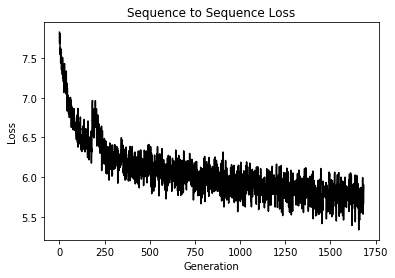

In [16]:
plt.plot(train_loss, 'k-')
plt.title('Sequence to Sequence Loss')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()